<a href="https://colab.research.google.com/github/PUBPOL-2130/notebooks/blob/main/future/migration-flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%config InlineBackend.figure_formats = ["retina"]

# Week 6: flows of people, people over time

In [2]:
!pip install -q geopandas networkx us census xlrd

In [3]:
import json

import geopandas as gpd
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import us

from census import Census
from shapely.geometry import Point

In [4]:
census = Census("", year=2020)

## ACS migration flows

In [5]:
state_fips = "36"

In [6]:
# alternate source (Musk-proofing): https://web.archive.org/web/20241226165446if_/https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2020/county-to-county-migration-2016-2020/county-to-county-migration-flows/Net_Gross_US.txt

raw_flows = requests.get(
    "https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2020/county-to-county-migration-2016-2020/county-to-county-migration-flows/Net_Gross_US.txt"
).content.decode("latin1").split("\n")

In [7]:
raw_flows[0]

'001001001003 Alabama                       Autauga County                      Alabama                       Baldwin County                            30       37      489      395     -459      396      519      398 '

In [9]:
# column names we figured out from finding an equivalent Excel spreadsheet
place_columns = (
    "a_fips",
    "b_fips",
    "a_state",
    "a_county",
    "b_state",
    "b_county",
)

flow_columns = (
    "b_to_a_flow_est",
    "b_to_a_flow_moe",
    "a_to_b_flow_est",
    "a_to_b_moe",
    "net_flow_est",
    "net_flow_moe",
    "gross_flow_est",
    "gross_flow_moe",
)

columns = (*place_columns, *flow_columns)

In [10]:
flows = []
for raw_flow in raw_flows[:-1]:
    flow_id = raw_flow[:raw_flow.index(" ")]
    if not all(c.isdigit() for c in flow_id):
        continue  # skip non-county flows

    assert len(flow_id) == 12, flow_id
    a_fips = flow_id[1:6]
    b_fips = flow_id[7:]

    remainder = raw_flow[raw_flow.index(" "):]
    parts = [a_fips, b_fips] + [part.strip() for part in remainder.split("  ") if part.strip()]
    flows.append({col: val for col, val in zip(columns, parts)})

In [11]:
flow_df = pd.DataFrame(flows).set_index(["a_fips", "b_fips"])
for col in flow_columns:
    flow_df[col] = flow_df[col].astype(int)

This makes sure there are no null values.  We'll sum a bunch of values and check that the total isn't `NaN`.

In [12]:
assert not flow_df["a_to_b_flow_est"].isna().sum()

In [13]:
nyc_county_fips_codes = {
    "The Bronx": "36005",      # Bronx County
    "Brooklyn": "36047",       # Kings County
    "Manhattan": "36061",      # New York County
    "Queens": "36081",         # Queens County
    "Staten Island": "36085",  # Richmond
}

Now we read in a county shapefile and put it in the Atlas Equal-Area CRS.

In [14]:
county_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/tl_2020_us_county.zip").set_index("GEOID").to_crs("EPSG:2163")

Let's narrow that gdf down to the NYC counties.  We have a dictionary where the county names are the keys, followed by FIPS codes as the values.  Let's list those values.

In [16]:
print(nyc_county_fips_codes.values())

dict_values(['36005', '36047', '36061', '36081', '36085'])


That functions as a list.  When we filter the geodataframe by that list, it will give us the rows with those FIPS codes.

In [15]:
nyc_county_gdf = county_gdf.loc[nyc_county_fips_codes.values()]

In [17]:
migration_graph = nx.DiGraph()
net_migration_graph = nx.DiGraph()

for a_county, a_county_fips in nyc_county_fips_codes.items():
    for b_county, b_county_fips in nyc_county_fips_codes.items():
        if a_county == b_county:
            continue

        flow = flow_df.loc[(a_county_fips, b_county_fips)]
        net_flow = flow["net_flow_est"]
        if net_flow >= 0:
            net_migration_graph.add_edge(
                a_county,
                b_county,
                weight=net_flow,
            )
        else:
            net_migration_graph.add_edge(
                b_county,
                a_county,
                weight=-net_flow,
            )

In [18]:
def cast_point(p):
    return (p.xy[0][0], p.xy[1][0])

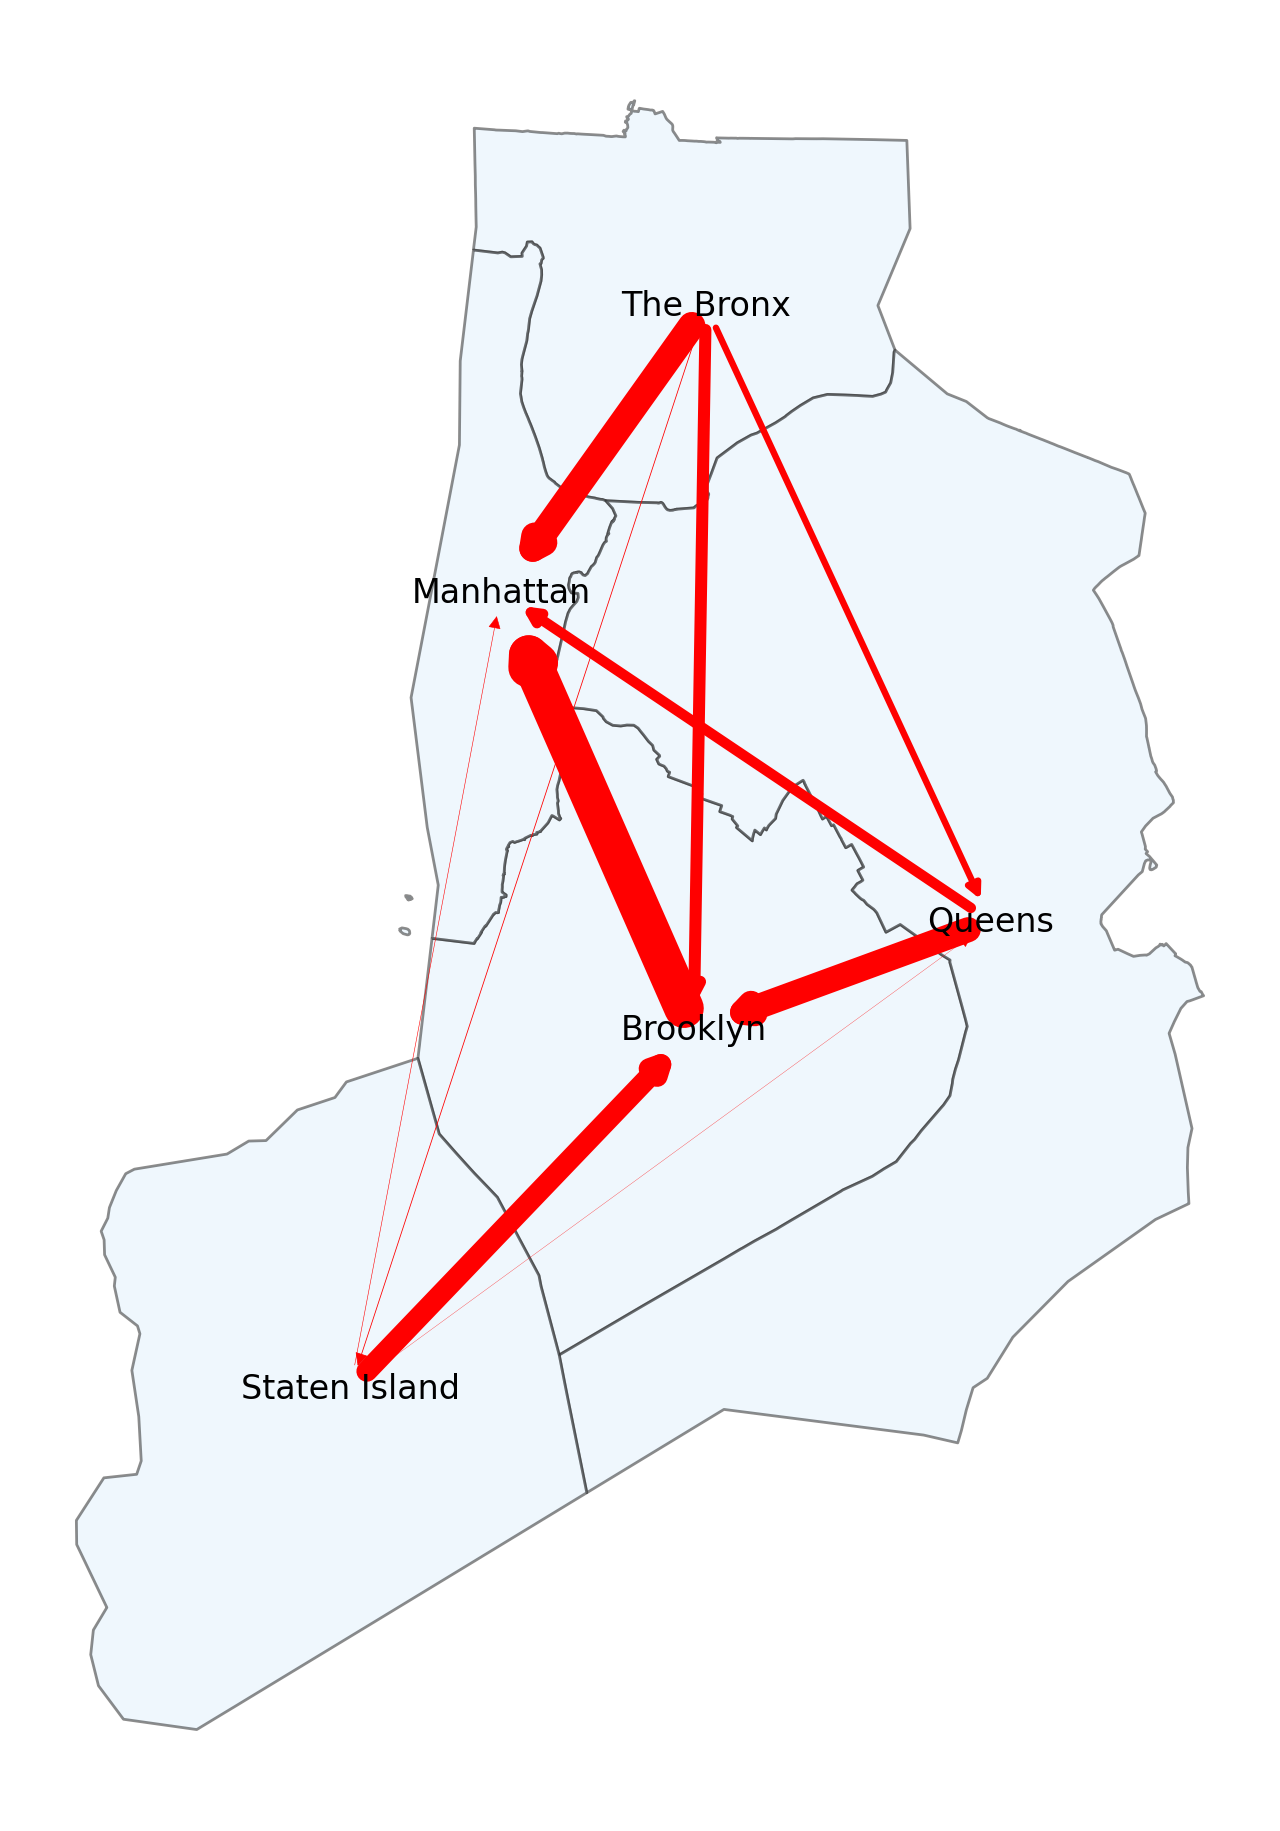

In [20]:
fig, ax = plt.subplots(figsize=(8, 16))
ax.axis("off")
nyc_county_gdf.plot(ax=ax, edgecolor="0.1", linewidth=1, color="#e1f1fd", alpha=0.5)

pos = {
    borough: cast_point(nyc_county_gdf.loc[county_fips].geometry.representative_point())
    for borough, county_fips in nyc_county_fips_codes.items()
}
#nx.draw_networkx_nodes(net_migration_graph, pos, ax=ax)
nx.draw_networkx_labels(net_migration_graph, pos, ax=ax)

for edge in net_migration_graph.edges(data='weight'):
    nx.draw_networkx_edges(net_migration_graph, pos, edgelist=[edge], width=0.0015 * edge[2], ax=ax, edge_color="red")

## PUMS migration flows

In [ ]:
rac1p = {
    "1": "white",  # White alone
    "2": "black",  # Black or African American alone
    "3": "amin",   # "American Indian alone",
    "4": "amin",   # Alaska Native alone
    "5": "amin",   # "American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races",
    "6": "aapi",   # "Asian alone",
    "7": "aapi",   # "Native Hawaiian and Other Pacific Islander alone",
    "8": "other",  # "Some other race alone",
    "9": "two_or_more",  # "Two or More Races"
}

In [ ]:
pums_results = []
puma_gdfs = []

for state in us.states.STATES:
    print(state)

    state_pums_response = requests.get(
        "https://api.census.gov/data/2023/acs/acs1/pums"
        f"?get=MIGSP,MIGPUMA,RAC1P&for=public%20use%20microdata%20area:*&in=state:{state.fips}"
    ).json()
    pums_results += state_pums_response[1:]

    puma_gdfs.append(
        gpd.read_file(
            f"https://www2.census.gov/geo/tiger/TIGER2024/PUMA20/tl_2024_{state.fips}_puma20.zip"
        )
    )

In [ ]:
json.dump(pums_results, open("data_archive/pums_results.json", "w"))

In [ ]:
pumas_gdf = gpd.GeoDataFrame(pd.concat(puma_gdfs), crs=puma_gdfs[0].crs).set_index("GEOID20")

In [ ]:
pumas_gdf.to_file("data_archive/pumas")

In [ ]:
puma_points_gdf = gpd.GeoDataFrame(
    {
        "geometry": pumas_gdf.apply(
            lambda row: Point(float(row["INTPTLON20"]), float(row["INTPTLAT20"])),
            axis=1,
        ),
        "name": pumas_gdf["NAMELSAD20"],
        "lat": pumas_gdf["INTPTLAT20"].astype(float),
        "lon": pumas_gdf["INTPTLON20"].astype(float),
    },
    crs=pumas_gdf.crs,
)

In [ ]:
puma_points_gdf

In [ ]:
excluded_migpumas = (
    "00001",  # Did not live in the United States or in Puerto Rico one year ago
    "00002",  # Lived in Puerto Rico one year ago and current residence is in the United States
    "N",      # N/A (person less than 1 year old/lived in same house 1 year ago)
)

In [ ]:
puma_df = pd.DataFrame(pums_results, columns=["migsp", "migpuma", "race", "state", "puma"])
puma_df["race"] = puma_df["race"].map(rac1p)

In [ ]:
puma_flows_df = puma_df[puma_df["migsp"].str.startswith("0")].copy()
puma_flows_df["from"] = puma_flows_df["migsp"].str.slice(1) + puma_flows_df["migpuma"]
puma_flows_df["to"] = puma_df["state"] + puma_flows_df["puma"]
puma_flows_df = puma_flows_df[["from", "to", "race"]]
puma_flows_df

In [ ]:
state_gdf = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2024/STATE/tl_2024_us_state.zip").set_index("GEOID").to_crs("EPSG:2163")

In [ ]:
proj_puma_points = dict(puma_points_gdf.to_crs("EPSG:2163")["geometry"])

In [ ]:
flow_state = "06"

In [ ]:
for race in puma_flows_df["race"].unique():
        race_flows_df = puma_flows_df[puma_flows_df["race"] == race]
        in_flow_counts = race_flows_df[race_flows_df["to"].str.startswith(flow_state)].groupby(by=["from", "to"]).size()
        out_flow_counts = race_flows_df[race_flows_df["from"].str.startswith(flow_state)].groupby(by=["from", "to"]).size()

        ax = state_gdf.plot(
            figsize=(40, 20),
            edgecolor="0.1",
            linewidth=0.4,
            color="#e1f1fd",
        )

        for flow_counts, color in zip((in_flow_counts, out_flow_counts), ("red", "blue")):
            for (flow_from, flow_to), count in flow_counts.items():
                try:
                    from_x, from_y = proj_puma_points[flow_from].coords.xy
                    to_x, to_y = proj_puma_points[flow_to].coords.xy
                except KeyError:
                    continue

                ax.plot([from_x[0], to_x[0]], [from_y[0], to_y[0]], color=color, linewidth=0.5 * count, alpha=0.3)

        ax.axis("off")
        ax.set_title(f"{race} migration (in: red, out: blue)")
        plt.show()

## Advanced flow visualizations with FlowmapBlue

In [ ]:
!pip install "git+https://github.com/PUBPOL-2130/notebooks#egg=pubpol2130&subdirectory=lib"

In [ ]:
from pubpol2130 import google_sheets_credentials, generate_flow_sheet

In [ ]:
sheet_creds = google_sheets_credentials()

### ACS

In [ ]:
county_flowmap_locations_df = county_gdf[["NAMELSAD", "INTPTLON", "INTPTLAT"]].reset_index().rename(
    columns={"NAMELSAD": "name", "INTPTLON": "lon", "INTPTLAT": "lat", "GEOID": "id"}
)
county_flowmap_locations_df

In [ ]:
a_to_b_acs_flow_counts = flow_df.reset_index()[["a_fips", "b_fips", "a_to_b_flow_est"]].rename(
    columns={"a_fips": "origin", "b_fips": "dest", "a_to_b_flow_est": "count"}
)
b_to_a_acs_flow_counts = flow_df.reset_index()[["a_fips", "b_fips", "b_to_a_flow_est"]].rename(
    columns={"b_fips": "origin", "a_fips": "dest", "b_to_a_flow_est": "count"}
)
acs_flow_counts = pd.concat([a_to_b_acs_flow_counts, b_to_a_acs_flow_counts])

In [ ]:
acs_flow_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=county_flowmap_locations_df.sort_values(by=["id"]),
    sheet_title="PUBPOL 2130: ACS migration flows",
    flow_title="U.S. Census ACS county-to-county migration flows, 2016-2020",
    incoming_tooltip="People in",
    outgoing_tooltip="People out",
    flow_tooltip="People",
    total_unit="people",
    data_source_name="U.S. Census ACS county-to-county migration flows, 2016-2020",
    data_source_url="https://www.census.gov/programs-surveys/acs",
    flows={"2016-2020": acs_flow_counts},
)

In [ ]:
print(acs_flow_sheet.url)

In [ ]:
print(f"https://www.flowmap.blue/{acs_flow_sheet.url.split('/')[-1]}")

#### Aggregating up to the state level

In [ ]:
state_flowmap_locations_df = state_gdf[["NAME", "INTPTLON", "INTPTLAT"]].reset_index().rename(
    columns={"NAME": "name", "INTPTLON": "lon", "INTPTLAT": "lat", "GEOID": "id"}
)

In [ ]:
state_acs_flow_counts = acs_flow_counts.copy()
state_acs_flow_counts["origin"] = state_acs_flow_counts["origin"].str[:2]
state_acs_flow_counts["dest"] = state_acs_flow_counts["dest"].str[:2]
state_acs_flow_counts = state_acs_flow_counts.groupby(by=["origin", "dest"]).sum().reset_index()

# Exclude intra-state flows.
state_acs_flow_counts = state_acs_flow_counts[
    state_acs_flow_counts["origin"] != state_acs_flow_counts["dest"]
]
state_acs_flow_counts

In [ ]:
state_acs_flow_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=state_flowmap_locations_df,
    sheet_title="PUBPOL 2130: ACS migration flows (interstate)",
    flow_title="U.S. Census ACS interstate migration flows, 2016-2020",
    incoming_tooltip="People in",
    outgoing_tooltip="People out",
    flow_tooltip="People",
    total_unit="people",
    data_source_name="U.S. Census ACS state-to-state migration flows, 2016-2020",
    data_source_url="https://www.census.gov/programs-surveys/acs",
    flows={"2016-2020": state_acs_flow_counts},
)

In [ ]:
print(state_acs_flow_sheet.url)

In [ ]:
print(f"https://www.flowmap.blue/{state_acs_flow_sheet.url.split('/')[-1]}")

### PUMS

In [ ]:
migpuma_by_puma_df = pd.read_excel("https://usa.ipums.org/usa/resources/volii/puma_migpuma1_pwpuma00_2020.xls", dtype=str)

migpuma_by_puma_df["puma_geoid"] = (
    migpuma_by_puma_df["State of Residence (ST)"]
    + migpuma_by_puma_df["PUMA"]
)

migpuma_by_puma_df["migpuma_geoid"] = (
    migpuma_by_puma_df["Place of Work State (PWSTATE2) or Migration State (MIGPLAC1)"]
    + migpuma_by_puma_df["PWPUMA00 or MIGPUMA1"]
).str[1:]

migpuma_by_puma_df = migpuma_by_puma_df[["puma_geoid", "migpuma_geoid"]].set_index("migpuma_geoid").sort_values(by="puma_geoid")

In [ ]:
exclude_migpumas = {"7200002", "1100100"}
exclude_pumas = {"1100101"}

In [ ]:
puma_flowmap_locations_df = puma_points_gdf.drop(columns=["geometry"])
puma_flowmap_locations_df.index.names = ["id"]
puma_flowmap_locations_df

In [ ]:
# For the purposes of visualization, arbitrarily assign ambiguous MIGPUMAs to the
# first corresponding PUMA (in lexographic order).
missing_migpumas = (set(puma_flows_df["from"]) | set(puma_flows_df["to"])) - set(proj_puma_points)
migpuma_rows = []

for missing_migpuma in missing_migpumas - exclude_migpumas:
    puma_geoid = migpuma_by_puma_df.loc[missing_migpuma].iloc[0]["puma_geoid"]
    if puma_geoid in exclude_pumas:
        continue

    migpuma_rows.append({
        "id": missing_migpuma,
        **puma_flowmap_locations_df.loc[puma_geoid],
    })

puma_flowmap_locations_df = pd.concat([
    puma_flowmap_locations_df,
    pd.DataFrame(migpuma_rows).set_index("id"),
])

In [ ]:
filtered_puma_flows_df = puma_flows_df[
    ~puma_flows_df["from"].isin(exclude_migpumas)
    & ~puma_flows_df["to"].isin(exclude_pumas)
]

In [ ]:
display_names = {
    "white": "White",
    "black": "Black or African American",
    "amin": "American Indian or Alaska Native",
    "aapi": "Asian; Native Hawaiian or Other Pacific Islander",
    "other": "Some Other Race",
    "two_or_more": "Two or More Races",
}

In [ ]:
puma_flows_df

In [ ]:
flows_by_race = {}

for race in puma_flows_df["race"].unique():
        race_flows_df = filtered_puma_flows_df[filtered_puma_flows_df["race"] == race].groupby(
            by=["from", "to"]
        ).size()
        flows_by_race[display_names[race]] = race_flows_df.reset_index().rename(
            columns={"from": "origin", "to": "dest", 0: "count"}
        )

In [ ]:
flow_by_race_sheet = generate_flow_sheet(
    sheet_creds=sheet_creds,
    locations_df=puma_flowmap_locations_df.reset_index(),
    sheet_title="PUBPOL 2130: PUMS migration flows",
    flow_title="U.S. Census PUMS migration flows, 2023",
    incoming_tooltip="People in",
    outgoing_tooltip="People out",
    flow_tooltip="People",
    total_unit="people",
    data_source_name="U.S. Census PUMS migration flows, 2023",
    data_source_url="https://www.census.gov/programs-surveys/acs/microdata.html",
    flows=flows_by_race,
)

In [ ]:
print(flow_by_race_sheet.url)

In [ ]:
print(f"https://www.flowmap.blue/{flow_by_race_sheet.url.split('/')[-1]}")